<a href="https://colab.research.google.com/github/fajrunwm/rac/blob/main/rac_vit_combined_data_mured_odir_v2c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setup
!pip install -q timm torch torchvision scikit-learn opencv-python tqdm

In [3]:
# Imports
import os, cv2, math, time, copy
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, hamming_loss

In [4]:
# Config
DATA_CSV   = "/content/drive/My Drive/RAC-Classification/Dataset/Combined Mured_ODIR/combined_22_labels_v3/train_images.csv"     # labels CSV
main_root = "/content/drive/My Drive/RAC-Classification/Dataset/Combined Mured_ODIR/combined_22_labels_v3/images"
fallback_root = "/content/drive/My Drive/RAC-Classification/Dataset/MuReD_version_2/Dataset/ori_balanced_fixed_N_DN/images"
fallback_root_2 = "/content/drive/My Drive/RAC-Classification/Dataset/ODIR-5K/training"

# IMG_ROOT   = "/content/drive/My Drive/RAC-Classification/Dataset/Combined Mured & ODIR/balanced_images"             # folder with images

In [5]:
import os

paths_to_check = [DATA_CSV, main_root, fallback_root, fallback_root_2]

for path in paths_to_check:
    if os.path.exists(path):
        print(f"Path exists: {path}")
    else:
        print(f"Path not found: {path}")

Path exists: /content/drive/My Drive/RAC-Classification/Dataset/Combined Mured_ODIR/combined_22_labels_new/combined_22_labels_new.csv
Path exists: /content/drive/My Drive/RAC-Classification/Dataset/Combined Mured_ODIR/combined_22_labels_new/images
Path exists: /content/drive/My Drive/RAC-Classification/Dataset/MuReD_version_2/Dataset/ori_balanced_fixed_N_DN/images
Path exists: /content/drive/My Drive/RAC-Classification/Dataset/ODIR-5K/training


In [5]:
IMG_SIZE   = 224             # set to 224 or 512
CLAHE_MODE = "clahe"         # "clahe", "histeq", or "none"
NUM_EPOCHS = 15
BATCH_SIZE = 16
LR         = 1e-4
WEIGHT_DECAY = 5e-5
WARMUP_EPOCHS = 1
EARLY_STOP_PATIENCE = 5
MODEL_NAME = "vit_base_patch16_224"    # can change to vit_large_* or vit_small_*
# OUT_DIR    = "runs_mured_vit"
# os.makedirs(OUT_DIR, exist_ok=True)
OUT_DIR    = "/content/drive/My Drive/RAC-Classification/Dataset/Combined Mured_ODIR/Output/4c/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 11
torch.manual_seed(seed); np.random.seed(seed)

In [6]:
device_type = str(device)
print(device_type)

cuda


In [7]:
# Utilities: CLAHE / Histogram Equalization
def apply_clahe_rgb(img_bgr):
    # Convert to LAB, apply CLAHE on L, then back to BGR
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2, a, b))
    bgr2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
    return bgr2

def apply_histeq_rgb(img_bgr):
    # Histogram equalization on Y (luma) in YCrCb space
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y_eq = cv2.equalizeHist(y)
    ycrcb2 = cv2.merge((y_eq, cr, cb))
    bgr2 = cv2.cvtColor(ycrcb2, cv2.COLOR_YCrCb2BGR)
    return bgr2

def preprocess_cv2(path, mode="clahe"):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"cv2 failed to read image: {path}")
    img_bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise FileNotFoundError(f"Image not found: {path}")
    if mode == "clahe":
        img_bgr = apply_clahe_rgb(img_bgr)
    elif mode == "histeq":
        img_bgr = apply_histeq_rgb(img_bgr)
    # else "none": do nothing
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img_rgb)

In [8]:
# ---- helpers ---------------------------------------------------------------
from pathlib import Path
from collections import defaultdict
import os, cv2
import numpy as np
import torch
from torch.utils.data import Dataset

def index_images(roots, exts={".png",".jpg",".jpeg",".bmp",".tif",".tiff"}):
    files_by_name = defaultdict(list)
    for r in map(Path, roots):
        if not r.exists():
            print(f"[WARN] Root does not exist: {r}")
            continue
        for p in r.rglob("*"):
            if p.is_file() and p.suffix.lower() in exts:
                files_by_name[p.name.lower()].append(p)
    return files_by_name

def resolve_path(rel_or_name, roots, files_by_name):
    rp = Path(str(rel_or_name))
    # try direct join under each root
    for r in map(Path, roots):
        cand = r / rp
        if cand.exists():
            return str(cand)
    # fallback: filename only
    hits = files_by_name.get(rp.name.lower(), [])
    if hits:
        return str(hits[0])
    return None

def preprocess_cv2(path, img_size, mode=None):
    if path is None or not Path(path).exists():
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"cv2 failed to read image: {path}")

    # resize -> HxW
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    # to torch tensor CHW, float [0,1]
    img = img[:, :, ::-1]            # BGR->RGB
    img = np.transpose(img, (2, 0, 1)).astype(np.float32) / 255.0
    return torch.from_numpy(img)

def collate_skip_missing(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None
    xs, ys, metas = zip(*batch)
    return torch.stack(xs), torch.stack(ys), list(metas)

# ---- label extractor -------------------------------------------------------
# Works with dict or pandas.Series rows
def build_target_from_row(rec, label_cols=None):
    import pandas as pd
    assert label_cols is not None, "label_cols must be provided"
    if isinstance(rec, dict):
        vals = [int(rec.get(c, 0)) for c in label_cols]
    elif hasattr(rec, "__class__") and rec.__class__.__name__ == "Series":
        vals = [int(rec.get(c, 0)) for c in label_cols]
    else:
        raise TypeError(f"Unsupported record type: {type(rec)}")
    return torch.tensor(vals, dtype=torch.float32)

# ---- dataset ---------------------------------------------------------------
class MultiRootDataset(Dataset):
    def __init__(self, items, roots, label_cols, img_size,
                 clahe_mode=None, target_fn=build_target_from_row,
                 skip_missing=True, augment=False):
        """
        items: pandas.DataFrame or iterable of dict/Series with at least:
               - 'ID' column for image filename or relative path
               - multi-label columns in label_cols
        roots: [main_root, fallback_root]
        """
        self.roots = roots
        self.label_cols = list(label_cols)
        self.img_size = int(img_size)
        self.clahe_mode = clahe_mode
        self.target_fn = target_fn
        self.skip_missing = skip_missing
        self.augment = augment

        # normalize items to a list of rows (pandas Series) to keep dtypes/ints
        try:
            import pandas as pd
            if isinstance(items, pd.DataFrame):
                self.rows = [row for _, row in items.iterrows()]
            else:
                self.rows = list(items)
        except Exception:
            self.rows = list(items)

        self.files_by_name = index_images(self.roots)

        self.samples = []
        dropped = 0
        for row in self.rows:
            # row may be Series or dict
            img_id = row["ID"] if (hasattr(row, "__getitem__") and "ID" in row) else row.get("ID")
            full = resolve_path(img_id, self.roots, self.files_by_name)
            if full is None:
                if self.skip_missing:
                    dropped += 1
                    continue
            self.samples.append({"path": full, "row": row})
        print(f"[Dataset] kept {len(self.samples)} samples, dropped {dropped} missing.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        try:
            x = preprocess_cv2(s["path"], self.img_size, mode=self.clahe_mode)
            # simple augmentation example (horizontal flip)
            if self.augment:
                if torch.rand(1).item() < 0.5:
                    x = torch.flip(x, dims=[2])  # flip width
            y = self.target_fn(s["row"], label_cols=self.label_cols)
            return x, y, {"path": s["path"]}
        except FileNotFoundError:
            if self.skip_missing:
                return None
            raise

In [9]:
# # Dataset
# class CombinedDataset(Dataset):
#     def __init__(self, df, img_root, label_cols, img_size=224, clahe_mode="clahe", augment=True):
#         self.df = df.reset_index(drop=True)
#         self.img_root = img_root
#         self.label_cols = label_cols
#         self.img_size = img_size
#         self.clahe_mode = clahe_mode
#         self.augment = augment

#         # Base transforms (resize + normalize to ImageNet stats)
#         base = [
#             transforms.Resize((img_size, img_size)),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406],
#                                  [0.229, 0.224, 0.225]),
#         ]
#         # Augmentations
#         aug = []
#         if augment:
#             aug = [
#                 transforms.RandomHorizontalFlip(p=0.5),
#                 transforms.RandomVerticalFlip(p=0.2),
#                 transforms.RandomRotation(degrees=10),
#                 transforms.ColorJitter(brightness=0.2, contrast=0.2),
#                 transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
#             ]
#         self.transform = transforms.Compose(aug + base)

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row  = self.df.iloc[idx]
#         img_path = row['ID']
#         # Support relative filename in CSV or full path
#         full_path = img_path if os.path.isabs(img_path) else os.path.join(self.img_root, img_path)

#         # Preprocess with CLAHE / hist-eq via OpenCV, then PIL -> torchvision transforms
#         pil_img = preprocess_cv2(full_path, mode=self.clahe_mode)
#         x = self.transform(pil_img)

#         y = torch.tensor(row[self.label_cols].values.astype(np.float32))
#         return x, y, img_path

In [10]:
# Load CSV and split
df = pd.read_csv(DATA_CSV)   # if semicolon-separated

# Add image extension suffix to the 'ID' column if missing
def add_extension_if_missing(filename):
    # Check if filename already has an extension
    if '.' in filename and filename.split('.')[-1] in ['png', 'jpg', 'jpeg', 'bmp', 'tif', 'tiff']:
        return filename
    # If not, apply the conditional logic
    if 'aria' in filename:
        return filename + '.tif'
    else:
        # Default to .png if no extension and not an 'aria' file
        return filename + '.png'

df['ID'] = df['ID'].apply(add_extension_if_missing)
df.head()

,ID,DR,NORMAL,MH,ODC,TSLN,ARMD,DN,MYA,BRVO,...,RS,ODE,LS,CSR,HTR,ASR,CRS,OTHER,G,C
0,(0001)aria_d_26.tif,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,(0001)aria_d_27.tif,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,(0003)aria_d_29.tif,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,(0026)aria_d_27.tif,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,101.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
len(df)

3389

In [12]:
num_workers = min(2, os.cpu_count())

In [13]:
# Label columns = all except "ID"
non_label_cols = ['ID']
label_cols = [c for c in df.columns if c not in non_label_cols]
num_classes = len(label_cols)
print("Label columns:", label_cols)

Label columns: ['DR', 'NORMAL', 'MH', 'ODC', 'TSLN', 'ARMD', 'DN', 'MYA', 'BRVO', 'ODP', 'CRVO', 'CNV', 'RS', 'ODE', 'LS', 'CSR', 'HTR', 'ASR', 'CRS', 'OTHER', 'G', 'C']


In [14]:
len(label_cols)

22

In [17]:

class_counts = {}
for col in label_cols:
    class_counts[col] = df[col].sum()

for cls, count in class_counts.items():
    print(f"{count} {cls}")

372 DR
493 NORMAL
187 MH
276 ODC
187 TSLN
302 ARMD
206 DN
160 MYA
167 BRVO
180 ODP
171 CRVO
197 CNV
156 RS
152 ODE
162 LS
152 CSR
192 HTR
199 ASR
152 CRS
286 OTHER
182 G
214 C


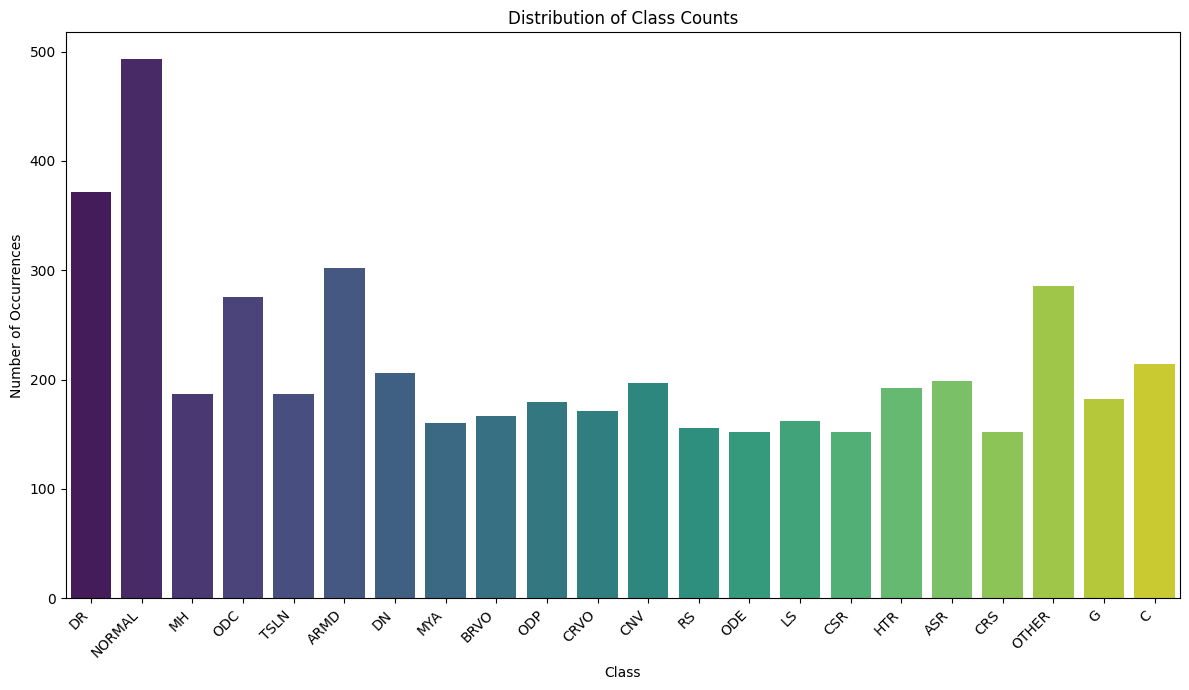

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the class_counts dictionary to a pandas DataFrame for easier plotting
class_counts_df = pd.DataFrame(class_counts.items(), columns=['Class', 'Count'])

# Sort the DataFrame by count for better visualization (optional)
# class_counts_df = class_counts_df.sort_values(by='Count', ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Class', y='Count', data=class_counts_df, palette='viridis', hue='Class', legend=False)
plt.title('Distribution of Class Counts')
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [20]:
def safe_getitem(ds, idx):
    try:
        return ds._getitem_strict(idx)
    except FileNotFoundError:
        return None

def collate_skip_missing(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None  # DataLoader will re-try next batch
    xs, ys, metas = zip(*batch)
    return torch.stack(xs), torch.stack(ys), list(metas)

In [21]:
# Basic split
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=seed)

train_ds = MultiRootDataset(items=train_df, roots=[main_root, fallback_root, fallback_root_2],
                           label_cols=label_cols, img_size=IMG_SIZE,
                           clahe_mode=CLAHE_MODE, target_fn=build_target_from_row,
                           skip_missing=True, augment=True)
val_ds   = MultiRootDataset(items=val_df, roots=[main_root, fallback_root, fallback_root_2],
                           label_cols=label_cols, img_size=IMG_SIZE,
                           clahe_mode=CLAHE_MODE, target_fn=build_target_from_row,
                           skip_missing=True, augment=False)

train_loader = DataLoader(train_ds,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=num_workers,
                          pin_memory=True,
                          collate_fn=collate_skip_missing)
val_loader   = DataLoader(val_ds,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=num_workers,
                          pin_memory=True,
                          collate_fn=collate_skip_missing)

[Dataset] kept 2711 samples, dropped 0 missing.
[Dataset] kept 678 samples, dropped 0 missing.


In [22]:
import os
from pathlib import Path
from collections import defaultdict

# Re-define index_images and resolve_path from MultiRootDataset to test
def index_images_test(roots, exts={'.png','.jpg','.jpeg','.bmp','.tif','.tiff'}):
    files_by_name = defaultdict(list)
    for r in map(Path, roots):
        if not r.exists():
            print(f"[WARN] Root does not exist: {r}")
            continue
        for p in r.rglob("*"):
            if p.is_file() and p.suffix.lower() in exts:
                files_by_name[p.name.lower()].append(p)
    return files_by_name

def resolve_path_test(rel_or_name, roots, files_by_name):
    rp = Path(str(rel_or_name))
    # try direct join under each root
    for r in map(Path, roots):
        cand = r / rp
        if cand.exists():
            return str(cand)
    # fallback: filename only
    hits = files_by_name.get(rp.name.lower(), [])
    if hits:
        return str(hits[0])
    return None


all_roots = [main_root, fallback_root, fallback_root_2]
indexed_files = index_images_test(all_roots)

missing_ids = []
for index, row in df.iterrows():
    img_id = row['ID']
    full_path = resolve_path_test(img_id, all_roots, indexed_files)
    if full_path is None:
        missing_ids.append(img_id)

print(f"Total missing IDs: {len(missing_ids)}")
if missing_ids:
    print("Examples of missing IDs:")
    for i, _id in enumerate(missing_ids[:10]): # Print first 10 missing IDs
        print(f"  {i+1}. {_id}")

Total missing IDs: 0


In [23]:
# Build ViT model (multi-label: use BCEWithLogitsLoss; no sigmoid in the head)
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes)
# timm heads already output logits; do NOT wrap with Sigmoid here
model.to(device)

criterion = nn.BCEWithLogitsLoss()

# AdamW + cosine schedule with warmup
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Simple cosine annealing schedule (epoch-based)

def cosine_lr(base_lr, epoch, max_epochs, warmup_epochs=0):
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / max(warmup_epochs, 1)
    e = epoch - warmup_epochs
    T = max(1, max_epochs - warmup_epochs)
    return base_lr * 0.5 * (1 + math.cos(math.pi * e / T))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [24]:
from sklearn.metrics import hamming_loss

def hamming_accuracy(y_true, y_pred):
    return 1 - hamming_loss(y_true, y_pred)

In [25]:
scaler = torch.amp.GradScaler(enabled=(device.type == "cuda"))
best_val_f1 = -1
best_wts = None
epochs_no_improve = 0

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

def evaluate(model, loader, threshold=0.5):
    model.eval()
    all_targets, all_probs = [], []
    val_loss = 0.0
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_targets.append(y.cpu().numpy())
    all_probs   = np.vstack(all_probs)
    all_targets = np.vstack(all_targets)

    preds_bin = (all_probs >= threshold).astype(int)
    f1_macro = f1_score(all_targets, preds_bin, average='macro', zero_division=0)
    val_acc = hamming_accuracy(all_targets, preds_bin)  # Hamming accuracy here
    return val_loss / len(loader.dataset), f1_macro, val_acc, all_targets, all_probs

# Create the output directory if it doesn't exist
os.makedirs(OUT_DIR, exist_ok=True)

for epoch in range(1, NUM_EPOCHS + 1):
    # adjust LR
    for g in optimizer.param_groups:
        g['lr'] = cosine_lr(LR, epoch-1, NUM_EPOCHS, warmup_epochs=WARMUP_EPOCHS)

    model.train()
    train_loss = 0.0
    train_preds, train_targets = [], []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}")
    for x, y, _ in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device_type, enabled=(device.type == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * x.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).int().cpu().numpy()
        train_preds.append(preds)
        train_targets.append(y.cpu().numpy())

        pbar.set_postfix(loss=loss.item())

    train_epoch_loss = train_loss / len(train_loader.dataset)
    train_preds = np.vstack(train_preds)
    train_targets = np.vstack(train_targets)
    train_acc = hamming_accuracy(train_targets, train_preds)
    train_acc_history.append(train_acc)

    val_epoch_loss, val_f1, val_acc, y_true, y_prob = evaluate(model, val_loader, threshold=0.5)
    val_acc_history.append(val_acc)

    train_loss_history.append(train_epoch_loss)
    val_loss_history.append(val_epoch_loss)

    print(f"Epoch {epoch}: "
          f"train_loss={train_epoch_loss:.4f} | val_loss={val_epoch_loss:.4f} | "
          f"val_f1={val_f1:.4f} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")

    # Early stopping on F1
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_wts = copy.deepcopy(model.state_dict())
        torch.save(best_wts, os.path.join(OUT_DIR, f"best_vit_state_dict_combined_ds_02c.pth"))
        torch.save({"state_dict": best_wts,
                    "label_cols": label_cols,
                    "model_name": MODEL_NAME,
                    "img_size": IMG_SIZE,
                    "clahe_mode": CLAHE_MODE}, os.path.join(OUT_DIR, "checkpoint_meta_combined_ds_02c.pth"))
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOP_PATIENCE:
            print("Early stopping.")
            break

# Load best weights back
if best_wts is not None:
    model.load_state_dict(best_wts)

Epoch 1/15: 100%|██████████| 170/170 [13:58<00:00,  4.93s/it, loss=0.171]


Epoch 1: train_loss=0.1748 | val_loss=0.1324 | val_f1=0.4397 | train_acc=0.9397 | val_acc=0.9523


Epoch 2/15: 100%|██████████| 170/170 [02:42<00:00,  1.04it/s, loss=0.0697]


Epoch 2: train_loss=0.1024 | val_loss=0.1049 | val_f1=0.6531 | train_acc=0.9622 | val_acc=0.9621


Epoch 3/15: 100%|██████████| 170/170 [02:59<00:00,  1.05s/it, loss=0.0496]


Epoch 3: train_loss=0.0661 | val_loss=0.0981 | val_f1=0.6778 | train_acc=0.9754 | val_acc=0.9643


Epoch 4/15: 100%|██████████| 170/170 [02:58<00:00,  1.05s/it, loss=0.0129]


Epoch 4: train_loss=0.0428 | val_loss=0.0885 | val_f1=0.7593 | train_acc=0.9846 | val_acc=0.9694


Epoch 5/15: 100%|██████████| 170/170 [02:58<00:00,  1.05s/it, loss=0.0092]


Epoch 5: train_loss=0.0273 | val_loss=0.0756 | val_f1=0.8049 | train_acc=0.9907 | val_acc=0.9746


Epoch 6/15: 100%|██████████| 170/170 [03:00<00:00,  1.06s/it, loss=0.0137]


Epoch 6: train_loss=0.0172 | val_loss=0.0767 | val_f1=0.8185 | train_acc=0.9943 | val_acc=0.9770


Epoch 7/15: 100%|██████████| 170/170 [02:59<00:00,  1.05s/it, loss=0.0038]


Epoch 7: train_loss=0.0106 | val_loss=0.0783 | val_f1=0.8216 | train_acc=0.9968 | val_acc=0.9769


Epoch 8/15: 100%|██████████| 170/170 [03:00<00:00,  1.06s/it, loss=0.00161]


Epoch 8: train_loss=0.0052 | val_loss=0.0848 | val_f1=0.8342 | train_acc=0.9986 | val_acc=0.9791


Epoch 9/15: 100%|██████████| 170/170 [02:56<00:00,  1.04s/it, loss=0.000894]


Epoch 9: train_loss=0.0030 | val_loss=0.0986 | val_f1=0.8113 | train_acc=0.9992 | val_acc=0.9779


Epoch 10/15: 100%|██████████| 170/170 [02:42<00:00,  1.05it/s, loss=0.000288]


Epoch 10: train_loss=0.0015 | val_loss=0.0891 | val_f1=0.8558 | train_acc=0.9997 | val_acc=0.9811


Epoch 11/15: 100%|██████████| 170/170 [03:01<00:00,  1.07s/it, loss=9.21e-5]


Epoch 11: train_loss=0.0004 | val_loss=0.0910 | val_f1=0.8667 | train_acc=0.9999 | val_acc=0.9825


Epoch 12/15: 100%|██████████| 170/170 [03:08<00:00,  1.11s/it, loss=5.77e-5]


Epoch 12: train_loss=0.0001 | val_loss=0.0945 | val_f1=0.8615 | train_acc=1.0000 | val_acc=0.9818


Epoch 13/15: 100%|██████████| 170/170 [02:56<00:00,  1.04s/it, loss=3.17e-5]


Epoch 13: train_loss=0.0001 | val_loss=0.0964 | val_f1=0.8669 | train_acc=1.0000 | val_acc=0.9824


Epoch 14/15: 100%|██████████| 170/170 [03:09<00:00,  1.12s/it, loss=3.51e-5]


Epoch 14: train_loss=0.0000 | val_loss=0.0974 | val_f1=0.8680 | train_acc=1.0000 | val_acc=0.9826


Epoch 15/15: 100%|██████████| 170/170 [03:07<00:00,  1.11s/it, loss=1.21e-5]


Epoch 15: train_loss=0.0000 | val_loss=0.0976 | val_f1=0.8663 | train_acc=1.0000 | val_acc=0.9824


In [26]:
torch.save(model.state_dict(), os.path.join(OUT_DIR, "model_weights_rac_combined_ds_vit_02c.pth"))
# save entire model (less recommended):
torch.save(model, os.path.join(OUT_DIR, "rac_combined_ds_vit_02c.pth"))

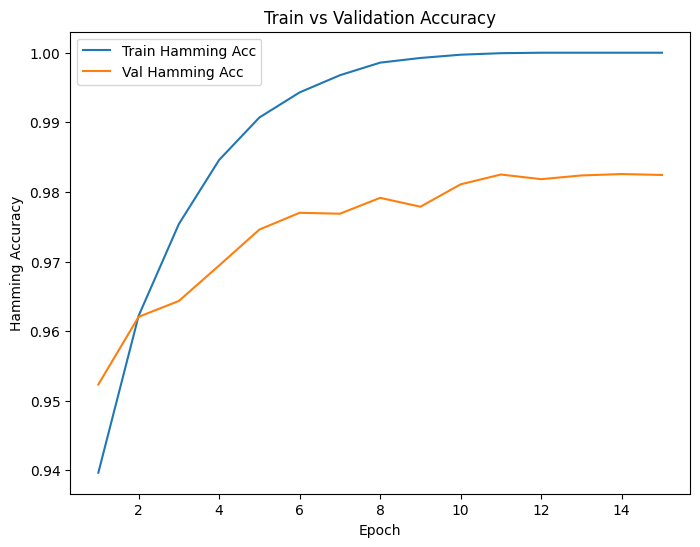

In [27]:
# Plot accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_acc_history)+1), train_acc_history, label="Train Hamming Acc")
plt.plot(range(1, len(val_acc_history)+1), val_acc_history, label="Val Hamming Acc")
plt.xlabel("Epoch")
plt.ylabel("Hamming Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()

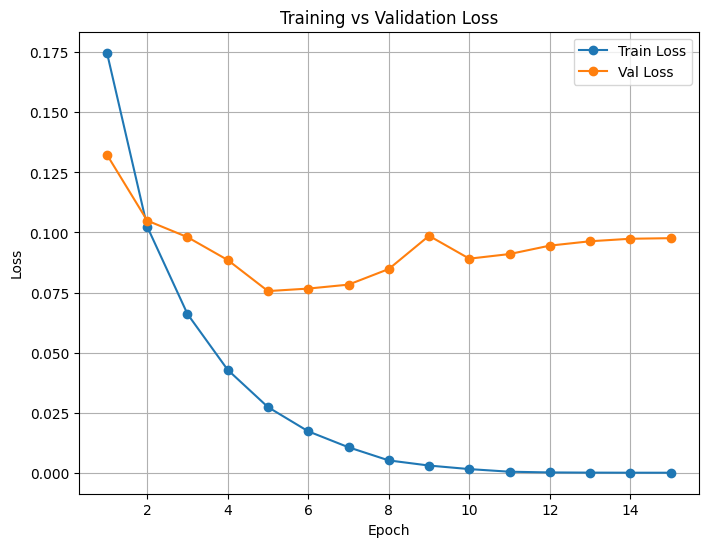

In [28]:
# Print Training vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss_history)+1), train_loss_history, label="Train Loss", marker='o')
plt.plot(range(1, len(val_loss_history)+1), val_loss_history, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

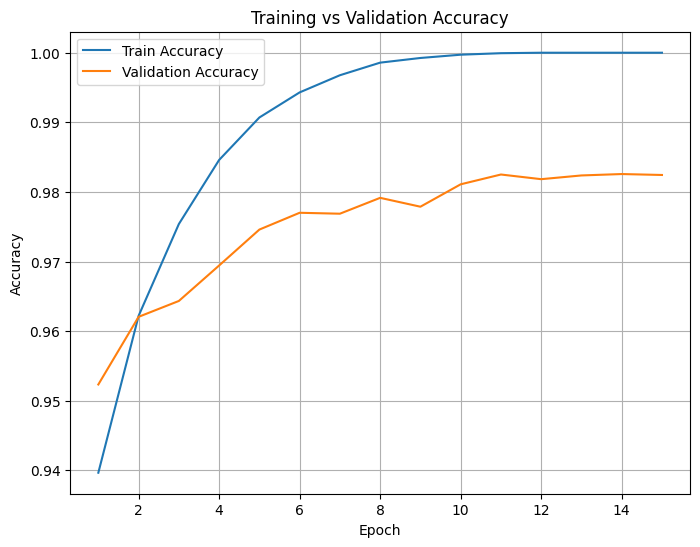

In [29]:
# Print Training vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Quick validation report at 0.5 threshold
model.eval()
_, f1m, val_acc, y_true, y_prob = evaluate(model, val_loader, threshold=0.5)
preds = (y_prob >= 0.5).astype(int)
print("Macro F1:", f1m)
print("Hamming Accuracy:", val_acc)
print(classification_report(y_true, preds, target_names=label_cols, zero_division=0))

Macro F1: 0.867991783593353
Hamming Accuracy: 0.9825690533655136
              precision    recall  f1-score   support

          DR       0.92      0.89      0.91        75
      NORMAL       0.73      0.76      0.75       102
          MH       0.96      0.66      0.78        38
         ODC       0.90      0.66      0.76        56
        TSLN       0.76      0.67      0.72        43
        ARMD       0.98      0.81      0.88        57
          DN       0.87      0.57      0.68        46
         MYA       0.90      0.85      0.88        33
        BRVO       0.95      0.68      0.79        31
         ODP       0.83      0.74      0.78        34
        CRVO       0.92      0.96      0.94        25
         CNV       0.97      0.97      0.97        30
          RS       0.97      0.97      0.97        29
         ODE       0.95      0.95      0.95        39
          LS       0.97      0.97      0.97        37
         CSR       1.00      0.86      0.93        22
         HTR    

              precision    recall  f1-score   support

           0       0.92      0.89      0.91        75
           1       0.73      0.76      0.75       102
           2       0.96      0.66      0.78        38
           3       0.90      0.66      0.76        56
           4       0.76      0.67      0.72        43
           5       0.98      0.81      0.88        57
           6       0.87      0.57      0.68        46
           7       0.90      0.85      0.88        33
           8       0.95      0.68      0.79        31
           9       0.83      0.74      0.78        34
          10       0.92      0.96      0.94        25
          11       0.97      0.97      0.97        30
          12       0.97      0.97      0.97        29
          13       0.95      0.95      0.95        39
          14       0.97      0.97      0.97        37
          15       1.00      0.86      0.93        22
          16       1.00      0.88      0.94        43
          17       1.00    

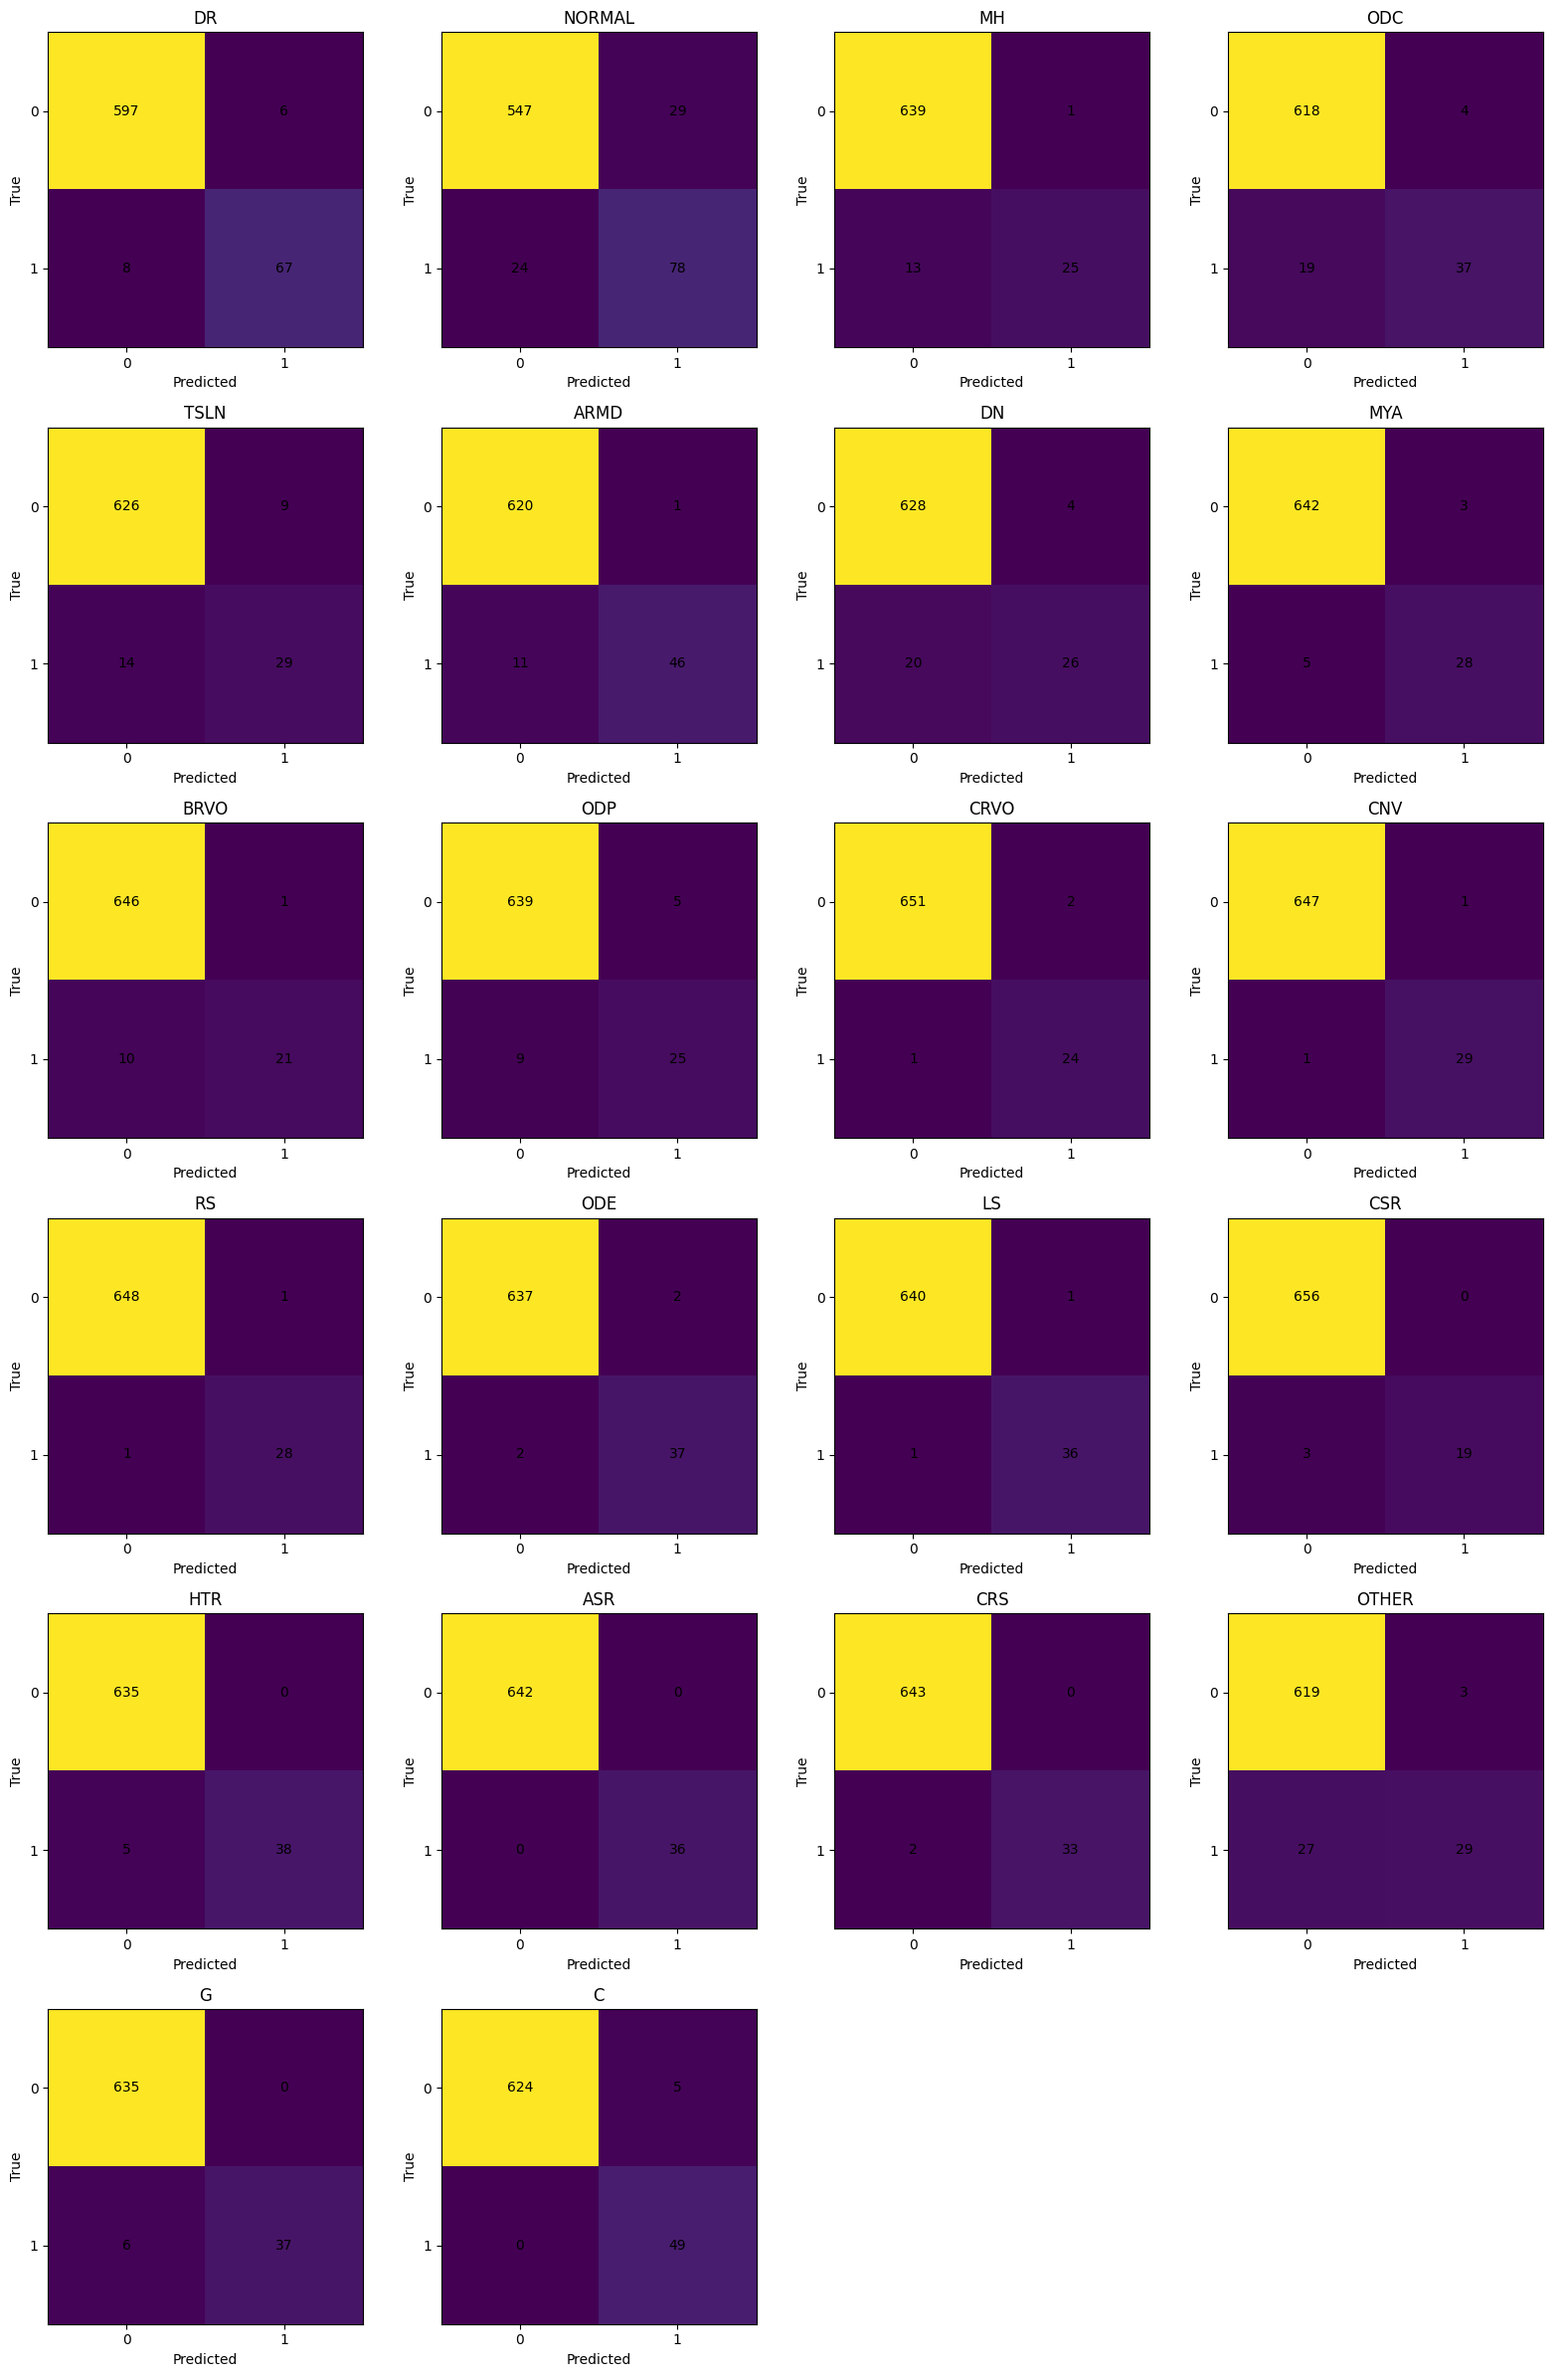

In [31]:
# Compute & show Confusion Matrix
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        if batch is None:     # collate_skip_missing can return None
            continue
        images, labels, _ = batch
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).int()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.vstack(all_preds).astype(int)
all_labels = np.vstack(all_labels).astype(int)

# One confusion matrix per class
ml_cms = multilabel_confusion_matrix(all_labels, all_preds)  # shape: (C, 2, 2)

# Optional: print a quick report
print(classification_report(all_labels, all_preds, zero_division=0))

# Visualize per-class confusion matrices
class_names = label_cols  # keep your label order
cols = 4
rows = int(np.ceil(len(class_names)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = np.atleast_1d(axes).ravel()

for i, (cm, name) in enumerate(zip(ml_cms, class_names)):
    ax = axes[i]
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([0,1]); ax.set_xticklabels(['0','1'])
    ax.set_yticks([0,1]); ax.set_yticklabels(['0','1'])
    # annotate counts
    for (r, c), v in np.ndenumerate(cm):
        ax.text(c, r, int(v), ha='center', va='center')
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()